In [ ]:
import os
from typing import Any, Literal, TypedDict

from flashrank import Ranker
from langchain.chains import RetrievalQA
from langchain.retrievers import ContextualCompressionRetriever, EnsembleRetriever
from langchain.retrievers.document_compressors import (
    DocumentCompressorPipeline,
    EmbeddingsFilter,
    LLMChainExtractor,
)
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_compressors import FlashrankRerank
from langchain_community.document_loaders import TextLoader
from langchain_community.document_transformers import EmbeddingsRedundantFilter
from langchain_community.retrievers import BM25Retriever
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_openai import ChatOpenAI
from langchain_semantic_cache import ensure_semantic_cache
from langchain_tavily import TavilySearch
from langgraph.graph import StateGraph
from pydantic import BaseModel, Field, ValidationError
from utils import display_markdown


class LearningModule(TypedDict):
    query: str


class IntentClassifier(BaseModel):
    intent: Literal["Learning", "Progress Check", "Help Request", "Goal Setting"] = (
        Field(
            description="The user's primary intent, chosen from one of the following: 'Learning', 'Progress Check', 'Help Request', or 'Goal Setting'."
        )
    )
    confidence: float = Field(
        description="A confidence score (between 0.0 and 1.0) indicating how certain the model is about the classified intent."
    )

In [ ]:
# cache = SemanticCache(
#     similarity_threshold=0.5, max_cache_size=1000, memory_cache_size=100
# )

In [ ]:
# cache.clear_cache()
ensure_semantic_cache()

In [ ]:
llm = ChatOpenAI(
    model="openai/gpt-4o-mini",
    temperature=0.7,
)

llm_intent = llm.with_structured_output(IntentClassifier)

In [ ]:
prompt = ChatPromptTemplate.from_template(
    """# Intent Classification Task

Classify the user query into exactly ONE category:
- **Learning**: Seeking knowledge, tutorials, explanations
- **Progress Check**: Reviewing status, tracking advancement
- **Help Request**: Troubleshooting, problem-solving assistance
- **Goal Setting**: Planning objectives, defining targets

## Output Format:
Category: [CATEGORY]
Confidence: [0.0-1.0]

## Examples:
Query: "How do I learn Python?"
Category: Learning
Confidence: 0.95

Query: "Am I on track with my fitness goals?"
Category: Progress Check
Confidence: 0.90

## User Query:
{query}"""
)

chain = prompt | llm_intent

In [ ]:
# chain.invoke("How can i be perfect for agentic ai interviews in the next 3 months?")  # type: ignore

# The Learning query preprocessing
## Knowledge base creation

In [ ]:
def document_processor(file_path: str) -> list[Document]:
    if not os.path.exists(file_path):
        print("The file path provided does not exist. Please check it again and retry")
        return None

    loader = TextLoader(file_path)
    docs = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    docs = text_splitter.split_documents(docs)

    return docs

In [ ]:
docs = document_processor("romeo.txt")

In [ ]:
def create_store(docs: list[Document], persist_dir: str, embeddings):
    if os.path.exists(persist_dir):
        print(f"Loaded the vector store from {persist_dir}")
        store = FAISS.load_local(
            persist_dir, embeddings, allow_dangerous_deserialization=True
        )

    else:
        if not docs:
            print("No documents were passed")
            return None

        if not os.path.exists(persist_dir):
            os.makedirs(persist_dir)
            print(f"Successfuly created the persist directory at {persist_dir}")

        print(f"Creating the new vector store with {len(docs)} documents")
        store = None

        for i in range(0, len(docs), 50):
            batch = docs[i : i + 50]

            print(
                f"Processing batch {i//50 + 1}/{(len(docs) + 49)//50} ({len(batch)} documents)"
            )
            if store is None:
                store = FAISS.from_documents(batch, embeddings)
            else:
                store.add_documents(batch)

        store.save_local(persist_dir)
        print(f"Vector store created and saved at {persist_dir}")

    return store

In [ ]:
embeddings = HuggingFaceEmbeddings(
    model_name="thenlper/gte-base", model_kwargs={"local_files_only": True}
)

In [ ]:
store = create_store(docs, "faiss_store", embeddings)

In [ ]:
ranker = Ranker(
    model_name="ms-marco-MiniLM-L-12-v2",
    cache_dir=os.path.expanduser("~/.cache/flashrank"),
)

In [ ]:
bm25_retriever = BM25Retriever.from_documents(docs)
bm25_retriever.k = 10
retriever = store.as_retriever(search_kwargs={"k": 10})  # type: ignore
retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, retriever], weights=[0.5, 0.5]
)

In [ ]:
retriever = store.as_retriever(search_kwargs={"k": 10})  # type: ignore
retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, retriever], weights=[0.5, 0.5]
)

In [ ]:
compressor_pipeline = DocumentCompressorPipeline(
    transformers=[
        EmbeddingsFilter(embeddings=embeddings, similarity_threshold=0.6),
        EmbeddingsRedundantFilter(embeddings=embeddings, similarity_threshold=0.95),
        FlashrankRerank(client=ranker),
        LLMChainExtractor.from_llm(llm),
    ]
)

In [ ]:
# compressor = FlashrankRerank(client=ranker)
retriever = ContextualCompressionRetriever(
    base_compressor=compressor_pipeline, base_retriever=retriever
)

In [ ]:
class LearningState(TypedDict):
    query: str
    qa_result: str
    relevant_docs: list[Document]
    learning_response: str
    user_profile: dict[str, Any]
    final_explanation: str
    learning_level: str
    learning_style: str
    difficulty_adjustments: str
    personalized_content: str
    learning_activities: list[str]
    related_topics: list[str]
    fallback_used: bool
    search_method: Literal["knowledge_base", "web_search"]

In [ ]:
tavily_search = TavilySearch(
    max_results=1,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=False,
)

In [ ]:
class MockDoc:
    def __init__(self, content, url):
        self.page_content = content
        self.metadata = {"source": url}

In [ ]:
def knowledge_base_search(state: LearningState):
    try:
        qa_chain = RetrievalQA.from_chain_type(
            llm=llm,
            chain_type="stuff",
            retriever=retriever,
            return_source_documents=True,
        )
        answer = qa_chain.invoke(state["query"])

        # LLM quality check
        if _is_adequate(answer["result"], state["query"]):
            return {
                **state,
                "qa_result": answer["result"],
                "relevant_docs": answer["source_documents"],
                "context_chunks": [
                    doc.page_content for doc in answer["source_documents"]
                ],
                "search_method": "knowledge_base",
                "fallback_used": False,
            }

    except Exception as e:
        print(f"Knowledge base search failed: {str(e)}")

    # Web search fallback
    try:
        web_results = tavily_search.invoke(
            f"Romeo and Juliet by Shakespeare: {state['query']}"
        )
        mock_docs = [
            MockDoc(res["content"], res["url"]) for res in web_results["results"]
        ]
        return {
            **state,
            "qa_result": web_results["answer"],
            "relevant_docs": mock_docs,
            "context_chunks": [res["content"] for res in web_results["results"]],
            "search_method": "web_search",
            "fallback_used": True,
        }
    except Exception as e:
        print(f"Web search failed: {str(e)}")

    return {
        **state,
        "qa_result": "I couldn't find relevant information about this topic.",
        "relevant_docs": [],
        "context_chunks": [],
        "search_method": "none",
        "fallback_used": True,
    }


def _is_adequate(answer: str, query: str) -> bool:
    """LLM judge for answer quality."""
    prompt = f"""Question: {query}
    Answer: {answer}

    Is this answer adequate for the Romeo and Juliet question? Consider if it's specific, relevant, and informative.
    Respond only: YES or NO"""

    try:
        # structured_llm = llm.with_structured_output
        response = llm.invoke(prompt)
        return "YES" in response.content.upper()
    except Exception as e:
        print(f"An Error occurred {str(e)}")
        return len(answer) > 50 and "don't know" not in answer.lower()


def generate_learning_response(state: LearningState):
    if not state.get("relevant_docs"):
        return {
            **state,
            "learning_response": "I couldn't find specific information about this topic in Romeo and Juliet. Please try rephrasing your question or ask about a different aspect of the play.",
        }

    context_text = "\n".join(
        [
            f"Context {i+1}:\n{doc.page_content}"
            for i, doc in enumerate(state.get("relevant_docs", []))
        ]
    )

    prompt_template = """You are a literature tutor for Romeo and Juliet.

    Initial Answer: {qa_result}
    Context: {context}
    User Query: {query}

    Provide an enhanced educational response with quotes, themes, and analysis.

    Enhanced Learning Response:"""

    prompt = ChatPromptTemplate.from_template(prompt_template)
    chain = prompt | llm | StrOutputParser()

    learning_response = chain.invoke(
        {
            "qa_result": state["qa_result"],
            "context": context_text,
            "query": state["query"],
        }
    )

    return {**state, "learning_response": learning_response}

In [ ]:
class PersonalizedEngine(BaseModel):
    personalized_content: str = Field(
        description="Adjusted complexity to match the learner's level with a maximum of 300 words."
    )
    learning_activities: list[str] = Field(
        description="A list of at most 5 tailored tasks or exercises to reinforce understanding."
    )
    related_topics: list[str] = Field(
        description="At most 5 topics closely connected to the main content for deeper exploration."
    )
    difficulty_adjustments: str = Field(
        description="Explanation of how the content difficulty was modified."
    )


class UserProfile(BaseModel):
    learning_level: str = "intermediate"
    learning_style: str = "visual"
    interests: list[str] = ["character_analysis", "themes"]
    previous_topics: list[str] = []


def content_personalization_engine(state: dict):
    # Error handling for user profile data
    profile_data = state.get("user_profile", {})
    try:
        profile = UserProfile(**profile_data)
    except ValidationError as e:
        print(f"Invalid profile data: {e}")
        profile = UserProfile()  # Use defaults

    if "learning_response" not in state:
        raise ValueError("learning_response is required in state")
    if "query" not in state:
        raise ValueError("query is required in state")

    learning_response = state["learning_response"]
    if len(learning_response) > 2000:
        learning_response = learning_response[:2000] + "..."

    personalization_prompt = ChatPromptTemplate.from_template(
        """Personalize this Romeo and Juliet content for a {learning_level} learner who prefers {learning_style} learning.

        Original content: {learning_response}

        KEEP ALL RESPONSES SHORT:
        - personalized_content: Rewrite for {learning_level} level (max 300 words)
        - learning_activities: List at most 5 activities (one sentence each)
        - related_topics: List at most 5 topic names only
        - difficulty_adjustments: What you changed (max 50 words)
        """
    )

    llm_structured = llm.with_structured_output(PersonalizedEngine)
    chain = personalization_prompt | llm_structured

    personalization_content = chain.invoke(
        {
            "learning_level": profile.learning_level,
            "learning_style": profile.learning_style,
            "interests": ", ".join(profile.interests),
            "previous_topics": ", ".join(profile.previous_topics),
            "learning_response": state["learning_response"],
            "query": state["query"],
        }
    )

    # Extract structured fields from the response
    return {
        **state,
        "personalized_content": personalization_content.personalized_content,  # type: ignore
        "learning_activities": personalization_content.learning_activities,  # type: ignore
        "related_topics": personalization_content.related_topics,  # type: ignore
        "difficulty_adjustments": personalization_content.difficulty_adjustments,  # type: ignore
        "learning_level": profile.learning_level,
        "learning_style": profile.learning_style,
    }

In [ ]:
def generate_explanation(state: LearningState):
    explanation_prompt = ChatPromptTemplate.from_template(
        """Answer this Romeo and Juliet question for a {learning_level} student:

        Question: {query}

        Content: {personalized_content}

        Activities: {learning_activities}

        Related topics: {related_topics}

        Keep your response under 300 words and make it engaging for a {learning_level} learner.
        """
    )

    chain = explanation_prompt | llm
    final_explanation = chain.invoke(
        {
            "query": state["query"],
            "learning_level": state.get("learning_level", "intermediate"),
            "learning_style": state.get("learning_style", "visual"),
            "personalized_content": state.get("personalized_content", ""),
            "learning_activities": "\n".join(state.get("learning_activities", [])),
            "related_topics": ", ".join(state.get("related_topics", [])),
            "difficulty_adjustments": state.get("difficulty_adjustments", ""),
        }
    )

    return {
        **state,
        "final_explanation": (
            final_explanation.content
            if hasattr(final_explanation, "content")
            else str(final_explanation)
        ),
    }

In [ ]:
# conn = sqlite3.connect("memory.db", check_same_thread=False)
# memory = SqliteSaver(conn)
# config = {"configurable": {"thread_id": "1"}}


workflow = StateGraph(LearningState)

# Add nodes
workflow.add_node("knowledge_base_search", knowledge_base_search)
workflow.add_node("generate_learning_response", generate_learning_response)
workflow.add_node("content_personalization_engine", content_personalization_engine)
workflow.add_node("generate_explanation", generate_explanation)

# Define edges

workflow.add_edge("knowledge_base_search", "generate_learning_response")
workflow.add_edge("generate_learning_response", "content_personalization_engine")
workflow.add_edge("content_personalization_engine", "generate_explanation")
workflow.set_entry_point("knowledge_base_search")

app = workflow.compile()  # Remove memory checkpointing

In [ ]:
result = app.invoke(
    {"query": "What are the key events that lead to Romeo and Juliet’s deaths?"},
    # config=config,
)

In [ ]:
%load_ext autoreload
%autoreload 2
display_markdown(result, title="Romeo and Juliet Analysis Results")

# 🎭 Romeo and Juliet Analysis Results

🎭 **Source:** Romeo & Juliet Knowledge Base

---

## ❓ Question

> **❝ What are the key events that lead to Romeo and Juliet’s deaths? ❞**

## 💡 Qa Result

The key events that lead to Romeo and Juliet's deaths include:  1. **Feud
between the Montagues and Capulets**: The longstanding rivalry between the two
families sets the stage for conflict and tragedy.  2. **Romeo and Juliet's
Secret Marriage**: Despite the feud, Romeo and Juliet fall in love and secretly
marry, hoping to unite their families.  3. **Tybalt's Death**: After Tybalt
kills Mercutio, Romeo avenges his friend's death by killing Tybalt, which leads
to Romeo's banishment from Verona.  4. **Juliet's Despair**: Juliet is
devastated by Tybalt's death and Romeo's banishment. In an attempt to avoid
marrying Paris, she seeks help from Friar Laurence.  5. **The Plan**: Friar
Laurence gives Juliet a potion that will make her appear dead for 42 hours,
allowing her to escape her marriage to Paris and reunite with Romeo.  6.
**Miscommunication**: The message about Juliet's fake death fails to reach
Romeo, leading him to believe she is truly dead.  7. **Romeo's Suicide**: In
despair, Romeo buys poison and goes to Juliet's tomb, where he encounters Paris
and kills him before taking the poison himself.  8. **Juliet's Awakening**:
Juliet awakens shortly after Romeo's death, finds him dead beside her, and takes
her own life with his dagger.  These events culminate in the tragic deaths of
both Romeo and Juliet, highlighting the consequences of their families' feud and
the miscommunications that arise from it.

## 📖 Learning Response

The tragic deaths of Romeo and Juliet are the result of a series of
interconnected events, deeply rooted in the themes of love, fate, and the
consequences of familial conflict. Below, we will explore these key events along
with relevant quotes, themes, and analyses that illustrate their significance
within the play.  ### Key Events Leading to Romeo and Juliet's Deaths  1. **Feud
Between the Montagues and Capulets**:      The play opens with a brawl between
the servants of the feuding families, underscoring the pervasive animosity and
its consequences. The Prince warns, “If ever you disturb our streets again, your
lives shall pay the forfeit of the peace” (Act 1, Scene 1). This feud creates a
hostile environment that directly affects Romeo and Juliet's ability to love
openly.  2. **Romeo and Juliet's Secret Marriage**:      Romeo and Juliet’s love
is powerful yet forbidden due to their families' enmity. They marry in secret,
believing their union might end the feud. Friar Laurence remarks, “For this
alliance may so happy prove / To turn your households' rancor to pure love” (Act
2, Scene 3), highlighting the hope that love can conquer hate.  3. **Tybalt's
Death**:      The turning point of the play occurs when Tybalt kills Mercutio,
prompting Romeo to seek revenge. Romeo declares, “I am fortune’s fool!” (Act 3,
Scene 1) after killing Tybalt, which leads to his banishment from Verona. This
act not only escalates the conflict but also separates the lovers, setting off a
chain of tragic events.  4. **Juliet's Despair**:      Juliet’s reaction to
Tybalt's death and Romeo's banishment is one of profound despair. She laments,
“O serpent heart, hid with a flowering face!” (Act 3, Scene 2), reflecting her
inner turmoil and the conflict between her love for Romeo and her grief over
Tybalt’s death. This despair leads her to seek a desperate solution to avoid
marrying Paris.  5. **The Plan**:      Friar Laurence devises a plan to help
Juliet escape her unwanted marriage. He gives her a potion that will simulate
death for 42 hours. He advises, “Take thou this vial;...If no unworthy hand /
Upon the crown of this unworthy head” (Act 4, Scene 1). This plan, while well-
intentioned, is fraught with risk and foreshadows the impending tragedy.  6.
**Miscommunication**:      The crucial failure of communication occurs when
Romeo does not receive the message about Juliet’s feigned death. Instead, he
learns of her death from Balthasar, who says, “Her body sleeps in Capel's
monument” (Act 5, Scene 1). This miscommunication is a pivotal moment that
propels the narrative towards its tragic conclusion.  7. **Romeo's Suicide**:
Believing Juliet to be dead, Romeo purchases poison and goes to her tomb. His
despair is encapsulated in his final words, “Here’s to my love!” (Act 5, Scene
3), as he takes the poison. This act of desperation underscores the theme of
tragic fate, as he believes there is no hope left without Juliet.  8. **Juliet's
Awakening**:      When Juliet awakens to find Romeo dead beside her, she takes
her own life with his dagger. Her final words, “O happy dagger! / This is thy
sheath” (Act 5, Scene 3), convey a tragic resolution to their love, suggesting
that death is the only escape from their suffering.   ### Themes and Analysis  -
**Love vs. Hate**: The intense love between Romeo and Juliet is set against the
backdrop of their families’ hatred. Their relationship symbolizes a hope for
reconciliation, but ultimately, the feud leads to their demise.  - **Fate and
Destiny**: The concept of fate is prevalent throughout the play, with references
to the "star-crossed lovers" suggesting that their deaths were predestined. The
characters often invoke fate, highlighting the lack of control they have over
their lives.  - **The Consequences of Impulsivity**: Many decisions in the play
are made hastily, leading to catastrophic outcomes. Romeo’s impulsive actions,
such as killing Tybalt and later taking his own life without understanding the
full context, emphasize the theme of rashness.  - **Miscommunication**: The
breakdown of communication between characters serves as a tragic device that
drives the plot. It illustrates how misunderstandings and lack of information
can lead to irreversible consequences.  In conclusion, the deaths of Romeo and
Juliet are the tragic result of societal pressures, familial loyalty, and the
uncontrollable forces of fate. Shakespeare masterfully intertwines these
elements, creating a poignant narrative that explores the depths of love and the
devastating impact of conflict and miscommunication.

## 🎯 Final Explanation

In *Romeo and Juliet*, the tragic deaths of the two young lovers unfold through
a series of crucial events influenced by love, fate, and family conflicts. Let’s
explore these key moments:  1. **Feud**: The bitter rivalry between the
Montagues and Capulets creates a dangerous environment in Verona. A street fight
breaks out, and the Prince warns both families to keep the peace, but the hatred
continues.  2. **Secret Marriage**: Despite the feud, Romeo and Juliet fall
deeply in love. They secretly marry with the hope that their love can heal their
families' hatred. Friar Laurence, who marries them, believes their union might
end the conflict.  3. **Tybalt's Death**: The tension escalates when Tybalt
kills Mercutio, Romeo’s friend. In revenge, Romeo kills Tybalt, which leads to
his banishment from Verona, tearing him away from Juliet.  4. **Juliet's
Despair**: Heartbroken by the events and facing an arranged marriage to Paris,
Juliet takes a potion that makes her appear dead. She hopes this will allow her
to run away with Romeo.  5. **Miscommunication**: Unfortunately, Romeo hears
about Juliet’s "death" and, in his grief, takes poison to join her in death.
When Juliet awakens and finds Romeo dead, she takes her own life.  Through these
events, Shakespeare emphasizes how love can thrive in a world filled with hate,
but also how misunderstandings and impulsive actions can lead to devastating
outcomes.   To engage with the story, consider creating a storyboard of these
events or drawing a comic strip to highlight the miscommunication between Romeo
and Juliet. You could also design a poster that showcases the main themes and
memorable quotes from the play!

---

## 📚 Additional Information

### 📋 Difficulty Adjustments

I simplified the language and reduced complex analyses to make the content more
accessible for intermediate learners.

### ✅ Learning Activities

✅ Create a storyboard illustrating the key events leading to the deaths of Romeo and Juliet.
✅ Make a mind map connecting the themes of love, fate, and impulsivity in the play.
✅ Draw a comic strip that shows the miscommunication between Romeo and Juliet.
✅ Watch a short film adaptation of Romeo and Juliet and discuss the differences with the original text.
✅ Design a poster that highlights the main themes and quotes from the play.

### 📚 Learning Level

intermediate

### 🎨 Learning Style

visual

### 📋 Personalized Content

In Romeo and Juliet, the tragic deaths of the two lovers happen due to several
events tied to love, fate, and family conflicts. Let's look at these events
visually:  1. **Feud**: The Montagues and Capulets hate each other. This feud
creates a dangerous world for Romeo and Juliet. A fight breaks out in the
streets, and the Prince warns both families to stop.     2. **Secret Marriage**:
Romeo and Juliet marry in secret, hoping their love will end the family feud.
The Friar believes their union can turn hate into love.     3. **Tybalt's
Death**: Tybalt kills Mercutio, and in revenge, Romeo kills Tybalt. This leads
to Romeo being banished from Verona, which separates the lovers.     4.
**Juliet's Despair**: Juliet is heartbroken after Tybalt's death and Romeo's
banishment. She decides to take a potion to avoid marrying Paris, thinking it
will help her.     5. **Miscommunication**: Romeo learns of Juliet's death (not
true) and takes poison. When Juliet awakes and finds Romeo dead, she takes her
own life.  Shakespeare shows how love can flourish amidst hate, but
misunderstandings and impulsive actions lead to tragedy.

### 🔗 Related Topics

🎭 Shakespeare's Life
🎭 Elizabethan Era
🎭 Tragic Heroes
🎭 Symbolism in Literature
🎭 Conflict Resolution

### 📜 Relevant Docs

### 📜 Text Reference 1
---
📖 **Source:** romeo.txt

> *"FIRST WATCH.
Sovereign, here lies the County Paris slain,
And Romeo dead, and Juliet, dead before,
Warm and new kill’d.

PRINCE.
Search, seek, and know how this foul murder comes.

CAPULET.
O heaven! O wife, look how our daughter bleeds!
This dagger hath mista’en, for lo, his house
Is empty on the b..."*

### 📜 Text Reference 2
---
📖 **Source:** romeo.txt

> *"Romeo, there dead, was husband to that Juliet,  
And she, there dead, that Romeo’s faithful wife.  
I married them; and their stol’n marriage day  
Was Tybalt’s doomsday, whose untimely death  
Banish’d the new-made bridegroom from this city;  
For whom, and not for Tybalt, Juliet pin’d."*

### 📜 Text Reference 3
---
📖 **Source:** romeo.txt

> *"NURSE.  
Tybalt is gone, and Romeo banished,  
Romeo that kill’d him, he is banished.  

JULIET.  
O God! Did Romeo’s hand shed Tybalt’s blood?"*



# Goal setting

In [ ]:
class AgentState(TypedDict):
    query: str
    goal: str
    smart_goal: str
    curriculum: list[str]
    learning_path: list[str]
    requirements: list[str]

In [ ]:
GOAL_SETTING_TEMPLATE = """You are an educational assistant. 
Create a clear, basic learning goal from the user's input.

User Input: {input}"""

SMART_GOAL_TEMPLATE = """Transform this goal into SMART format with specific metrics:
- Specific: Exactly what will be accomplished?
- Measurable: How will you track progress? (e.g., "complete 5 projects", "score 80% on exam")
- Achievable: Realistic timeframe and scope
- Relevant: Why this matters for the user's objectives  
- Time-bound: Specific deadline (e.g., "within 3 months")

Goal: {goal}"""

LEARNING_PATH_TEMPLATE = """Create a sequential learning path to achieving this SMART Goal
                        Break it down into logical, progressive steps that build upon each other.
                        SMART GOAL: {smart_goal}
                       
                        """

CURRICULUM_TEMPLATE = """Design a curriculum structure aligned with this learning path.
Create modules that support the learning objectives and path.

Learning Path: {learning_path}
SMART Goal: {smart_goal}
"""

PREREQUISITES_TEMPLATE = """Identify the prerequisites needed before starting this curriculum.
Consider knowledge, skills, tools, or resources required.

Curriculum: {curriculum}
SMART Goal: {smart_goal}
"""

In [ ]:
class Goal(BaseModel):
    goal: str = Field(description="A structured well formatted goal to be achieved")


class SmartGoal(BaseModel):
    smart_goal: str = Field(description="A SMART formatted goal with specific timeline")


class LearningPath(BaseModel):
    learning_path: list[str] = Field(
        description="Sequential learning steps to achieve the goal"
    )


class Curriculum(BaseModel):
    modules: list[str] = Field(
        description="Curriculum modules aligned with learning objectives"
    )


class Prerequisites(BaseModel):
    requirements: list[str] = Field(
        description="Prerequisites required before starting on the goal"
    )

In [ ]:
def goal_setting_node(state: AgentState):
    prompt = ChatPromptTemplate.from_template(GOAL_SETTING_TEMPLATE)
    structured_llm = llm.with_structured_output(Goal)
    chain = prompt | structured_llm

    result = chain.invoke({"input": state["query"]})
    return {**state, "goal": result.goal}


def smart_goal_node(state: AgentState):
    prompt = ChatPromptTemplate.from_template(SMART_GOAL_TEMPLATE)
    structured_llm = llm.with_structured_output(SmartGoal)

    chain = prompt | structured_llm

    result = chain.invoke({"goal": state["goal"]})
    return {**state, "smart_goal": result.smart_goal}


def learning_path_node(state: AgentState):
    prompt = ChatPromptTemplate.from_template(LEARNING_PATH_TEMPLATE)
    structured_llm = llm.with_structured_output(LearningPath)

    chain = prompt | structured_llm

    result = chain.invoke({"smart_goal": state["smart_goal"]})
    return {**state, "learning_path": result.learning_path}


def curriculum_node(state: AgentState):
    prompt = ChatPromptTemplate.from_template(CURRICULUM_TEMPLATE)
    structured_llm = llm.with_structured_output(Curriculum)

    chain = prompt | structured_llm

    result = chain.invoke(
        {"learning_path": state["learning_path"], "smart_goal": state["smart_goal"]}
    )
    return {**state, "curriculum": result.modules}


def prerequisite_checker_node(state: AgentState):
    prompt = ChatPromptTemplate.from_template(PREREQUISITES_TEMPLATE)
    structured_llm = llm.with_structured_output(Prerequisites)

    chain = prompt | structured_llm

    result = chain.invoke(
        {"curriculum": state["curriculum"], "smart_goal": state["smart_goal"]}
    )
    return {**state, "requirements": result.requirements}

In [ ]:
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("goal_setting_node", goal_setting_node)
workflow.add_node("smart_goal_node", smart_goal_node)
workflow.add_node("learning_path_node", learning_path_node)
workflow.add_node("curriculum_node", curriculum_node)
workflow.add_node("prerequisite_checker_node", prerequisite_checker_node)

# Add edges
workflow.add_edge("goal_setting_node", "smart_goal_node")
workflow.add_edge("smart_goal_node", "learning_path_node")
workflow.add_edge("learning_path_node", "curriculum_node")
workflow.add_edge("curriculum_node", "prerequisite_checker_node")

workflow.set_entry_point("goal_setting_node")
workflow.set_finish_point("prerequisite_checker_node")

graph = workflow.compile()

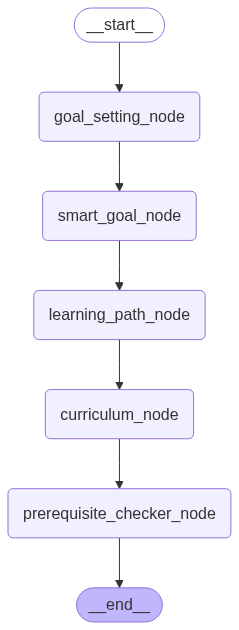

In [ ]:
graph

In [ ]:
user_query = "I need to learn machine learning in 6 months"
initial_state = {
    "query": user_query,
    "goal": "",
    "smart_goal": "",
    "learning_path": [],
    "curriculum": [],
    "prerequisites": [],
}

In [ ]:
graph.invoke(initial_state)

{'query': 'I need to learn machine learning in 6 months',
 'goal': 'Learn the fundamentals of machine learning within 6 months.',
 'smart_goal': 'Learn the fundamentals of machine learning and achieve a basic proficiency by completing at least 3 online courses and building 2 simple projects, with measurable progress tracked monthly, within a 6-month timeframe ending on October 31, 2024.',
 'curriculum': ['Introduction to Machine Learning Fundamentals: Cover supervised and unsupervised learning, understanding different types of algorithms and their applications.',
  'Key Algorithms Deep Dive: Focus on linear regression, decision trees, and clustering techniques, including their use cases and implementation basics.',
  'Practical Coding Exercises: Engage in small projects such as predicting housing prices or classifying images to reinforce learning and gain hands-on experience.',
  'Applied Machine Learning Projects: Develop and complete projects like housing price prediction or image cl